In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                     | 0/60000 [00:00<?, ?it/s]

 11%|███████████▋                                                                                           | 6781/60000 [00:00<00:00, 67798.26it/s]

 23%|███████████████████████                                                                               | 13561/60000 [00:00<00:00, 66683.32it/s]

 34%|██████████████████████████████████▍                                                                   | 20231/60000 [00:00<00:00, 66125.48it/s]

 45%|█████████████████████████████████████████████▊                                                        | 26979/60000 [00:00<00:00, 66652.83it/s]

 56%|█████████████████████████████████████████████████████████▎                                            | 33710/60000 [00:00<00:00, 66886.84it/s]

 67%|████████████████████████████████████████████████████████████████████▋                                 | 40400/60000 [00:00<00:00, 63272.57it/s]

 78%|███████████████████████████████████████████████████████████████████████████████▌                      | 46778/60000 [00:00<00:00, 63430.07it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████▎           | 53159/60000 [00:00<00:00, 63545.40it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎| 59569/60000 [00:00<00:00, 63714.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 64338.89it/s]

  0%|                                                                                                                     | 0/10000 [00:00<?, ?it/s]

 55%|████████████████████████████████████████████████████████▊                                              | 5520/10000 [00:00<00:00, 55190.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 56940.94it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 74x07uh4


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-74x07uh4:best, 409.59MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.8


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_ftr = []
trn_emb = []
trn_lgt = []
trn_tgt = []

val_inp = []
val_ftr = []
val_emb = []
val_lgt = []
val_tgt = []

ind_inp = []
ind_ftr = []
ind_emb = []
ind_lgt = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_ftr = []
    ood_emb = []
    ood_lgt = []
    ood_tgt = []

rnd_inp = []
rnd_ftr = []
rnd_emb = []
rnd_lgt = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_ftr.extend(ftr.detach().cpu().numpy())
    trn_emb.extend(emb.detach().cpu().numpy())
    trn_lgt.extend(lgt.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_ftr.extend(ftr.detach().cpu().numpy())
    val_emb.extend(emb.detach().cpu().numpy())
    val_lgt.extend(lgt.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_ftr.extend(ftr.detach().cpu().numpy())
    ind_emb.extend(emb.detach().cpu().numpy())
    ind_lgt.extend(lgt.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_ftr.extend(ftr.detach().cpu().numpy())
        ood_emb.extend(emb.detach().cpu().numpy())
        ood_lgt.extend(lgt.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_ftr.extend(ftr.detach().cpu().numpy())
    rnd_emb.extend(emb.detach().cpu().numpy())
    rnd_lgt.extend(lgt.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                       | 0/750 [00:00<?, ?it/s]

  0%|▏                                                                                                              | 1/750 [00:00<07:15,  1.72it/s]

  2%|█▊                                                                                                            | 12/750 [00:00<00:32, 22.96it/s]

  3%|███▌                                                                                                          | 24/750 [00:00<00:16, 43.62it/s]

  5%|█████▎                                                                                                        | 36/750 [00:00<00:11, 60.76it/s]

  6%|███████                                                                                                       | 48/750 [00:01<00:09, 73.95it/s]

  8%|████████▊                                                                                                     | 60/750 [00:01<00:08, 85.34it/s]

 10%|██████████▌                                                                                                   | 72/750 [00:01<00:07, 93.05it/s]

 11%|████████████▎                                                                                                 | 84/750 [00:01<00:06, 98.45it/s]

 13%|█████████████▉                                                                                               | 96/750 [00:01<00:06, 102.30it/s]

 14%|███████████████▌                                                                                            | 108/750 [00:01<00:06, 105.65it/s]

 16%|█████████████████▎                                                                                          | 120/750 [00:01<00:05, 108.05it/s]

 18%|███████████████████                                                                                         | 132/750 [00:01<00:05, 110.22it/s]

 19%|████████████████████▋                                                                                       | 144/750 [00:01<00:05, 111.31it/s]

 21%|██████████████████████▍                                                                                     | 156/750 [00:01<00:05, 111.96it/s]

 22%|████████████████████████▏                                                                                   | 168/750 [00:02<00:05, 111.32it/s]

 24%|█████████████████████████▉                                                                                  | 180/750 [00:02<00:05, 112.11it/s]

 26%|███████████████████████████▋                                                                                | 192/750 [00:02<00:04, 112.82it/s]

 27%|█████████████████████████████▍                                                                              | 204/750 [00:02<00:04, 113.05it/s]

 29%|███████████████████████████████                                                                             | 216/750 [00:02<00:04, 113.17it/s]

 30%|████████████████████████████████▊                                                                           | 228/750 [00:02<00:04, 113.83it/s]

 32%|██████████████████████████████████▌                                                                         | 240/750 [00:02<00:04, 113.62it/s]

 34%|████████████████████████████████████▎                                                                       | 252/750 [00:02<00:04, 113.99it/s]

 35%|██████████████████████████████████████                                                                      | 264/750 [00:02<00:04, 114.00it/s]

 37%|███████████████████████████████████████▋                                                                    | 276/750 [00:03<00:04, 114.41it/s]

 38%|█████████████████████████████████████████▍                                                                  | 288/750 [00:03<00:04, 114.70it/s]

 40%|███████████████████████████████████████████▏                                                                | 300/750 [00:03<00:03, 114.02it/s]

 42%|████████████████████████████████████████████▉                                                               | 312/750 [00:03<00:03, 113.96it/s]

 43%|██████████████████████████████████████████████▋                                                             | 324/750 [00:03<00:03, 114.22it/s]

 45%|████████████████████████████████████████████████▍                                                           | 336/750 [00:03<00:03, 114.26it/s]

 46%|██████████████████████████████████████████████████                                                          | 348/750 [00:03<00:03, 114.41it/s]

 48%|███████████████████████████████████████████████████▊                                                        | 360/750 [00:03<00:03, 114.34it/s]

 50%|█████████████████████████████████████████████████████▌                                                      | 372/750 [00:03<00:03, 114.24it/s]

 51%|███████████████████████████████████████████████████████▎                                                    | 384/750 [00:03<00:03, 114.06it/s]

 53%|█████████████████████████████████████████████████████████                                                   | 396/750 [00:04<00:03, 114.13it/s]

 54%|██████████████████████████████████████████████████████████▊                                                 | 408/750 [00:04<00:02, 114.04it/s]

 56%|████████████████████████████████████████████████████████████▍                                               | 420/750 [00:04<00:02, 113.74it/s]

 58%|██████████████████████████████████████████████████████████████▏                                             | 432/750 [00:04<00:02, 113.81it/s]

 59%|███████████████████████████████████████████████████████████████▉                                            | 444/750 [00:04<00:02, 113.56it/s]

 61%|█████████████████████████████████████████████████████████████████▋                                          | 456/750 [00:04<00:02, 113.55it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                        | 468/750 [00:04<00:02, 113.57it/s]

 64%|█████████████████████████████████████████████████████████████████████                                       | 480/750 [00:04<00:02, 113.46it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                     | 492/750 [00:04<00:02, 113.62it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                   | 504/750 [00:05<00:02, 114.05it/s]

 69%|██████████████████████████████████████████████████████████████████████████▎                                 | 516/750 [00:05<00:02, 112.74it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                | 528/750 [00:05<00:01, 113.07it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▊                              | 540/750 [00:05<00:01, 113.27it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▍                            | 552/750 [00:05<00:01, 113.44it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                          | 564/750 [00:05<00:01, 113.72it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▉                         | 576/750 [00:05<00:01, 113.37it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                       | 588/750 [00:05<00:01, 113.66it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▍                     | 600/750 [00:05<00:01, 113.65it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▏                   | 612/750 [00:05<00:01, 113.58it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▊                  | 624/750 [00:06<00:01, 113.64it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 636/750 [00:06<00:01, 113.66it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 648/750 [00:06<00:00, 113.44it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 660/750 [00:06<00:00, 113.45it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 672/750 [00:06<00:00, 113.51it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 684/750 [00:06<00:00, 113.27it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 696/750 [00:06<00:00, 113.26it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 708/750 [00:06<00:00, 113.35it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 720/750 [00:06<00:00, 113.27it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 732/750 [00:07<00:00, 113.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 744/750 [00:07<00:00, 113.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [00:07<00:00, 104.09it/s]

train - OK


  0%|                                                                                                                       | 0/188 [00:00<?, ?it/s]

  1%|▌                                                                                                              | 1/188 [00:00<00:38,  4.91it/s]

  7%|███████▌                                                                                                      | 13/188 [00:00<00:03, 51.14it/s]

 13%|██████████████▋                                                                                               | 25/188 [00:00<00:02, 74.98it/s]

 20%|█████████████████████▋                                                                                        | 37/188 [00:00<00:01, 88.83it/s]

 26%|████████████████████████████▋                                                                                 | 49/188 [00:00<00:01, 97.47it/s]

 32%|███████████████████████████████████▎                                                                         | 61/188 [00:00<00:01, 102.85it/s]

 39%|██████████████████████████████████████████▎                                                                  | 73/188 [00:00<00:01, 106.78it/s]

 45%|█████████████████████████████████████████████████▎                                                           | 85/188 [00:00<00:00, 109.56it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 97/188 [00:01<00:00, 111.07it/s]

 58%|██████████████████████████████████████████████████████████████▌                                             | 109/188 [00:01<00:00, 112.20it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                      | 121/188 [00:01<00:00, 113.08it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                               | 133/188 [00:01<00:00, 114.13it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 145/188 [00:01<00:00, 114.48it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▏                 | 157/188 [00:01<00:00, 115.49it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 169/188 [00:01<00:00, 115.69it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 181/188 [00:01<00:00, 115.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [00:01<00:00, 96.29it/s]

val - OK


  0%|                                                                                                                       | 0/157 [00:00<?, ?it/s]

  1%|▋                                                                                                              | 1/157 [00:00<00:33,  4.60it/s]

  8%|█████████                                                                                                     | 13/157 [00:00<00:02, 49.22it/s]

 16%|█████████████████▌                                                                                            | 25/157 [00:00<00:01, 73.19it/s]

 24%|█████████████████████████▉                                                                                    | 37/157 [00:00<00:01, 87.49it/s]

 31%|██████████████████████████████████▎                                                                           | 49/157 [00:00<00:01, 95.85it/s]

 39%|██████████████████████████████████████████▎                                                                  | 61/157 [00:00<00:00, 101.64it/s]

 46%|██████████████████████████████████████████████████▋                                                          | 73/157 [00:00<00:00, 105.63it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 85/157 [00:00<00:00, 108.24it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 97/157 [00:01<00:00, 110.15it/s]

 69%|██████████████████████████████████████████████████████████████████████████▉                                 | 109/157 [00:01<00:00, 111.31it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▏                        | 121/157 [00:01<00:00, 111.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 133/157 [00:01<00:00, 112.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 145/157 [00:01<00:00, 113.16it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 93.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 91.22it/s]

test InD - OK


  0%|                                                                                                                       | 0/100 [00:00<?, ?it/s]

 13%|██████████████▏                                                                                              | 13/100 [00:00<00:00, 121.19it/s]

 26%|████████████████████████████▎                                                                                | 26/100 [00:00<00:00, 121.56it/s]

 39%|██████████████████████████████████████████▌                                                                  | 39/100 [00:00<00:00, 121.31it/s]

 52%|████████████████████████████████████████████████████████▋                                                    | 52/100 [00:00<00:00, 120.04it/s]

 65%|██████████████████████████████████████████████████████████████████████▊                                      | 65/100 [00:00<00:00, 120.58it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████                        | 78/100 [00:00<00:00, 121.04it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 91/100 [00:00<00:00, 120.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 120.91it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(48000, 3, 32, 32) (48000, 2048) (48000, 256) (48000, 10) (48000,)
(12000, 3, 32, 32) (12000, 2048) (12000, 256) (12000, 10) (12000,)
(10000, 3, 32, 32) (10000, 2048) (10000, 256) (10000, 10) (10000,)
(6400, 3, 32, 32) (6400, 2048) (6400, 256) (6400, 10)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]

if ood_str:
    all_ftr = np.concatenate([ind_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([ind_lgt, ood_lgt], axis=0)
else:
    all_ftr = ind_ftr
    all_lgt = ind_lgt

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


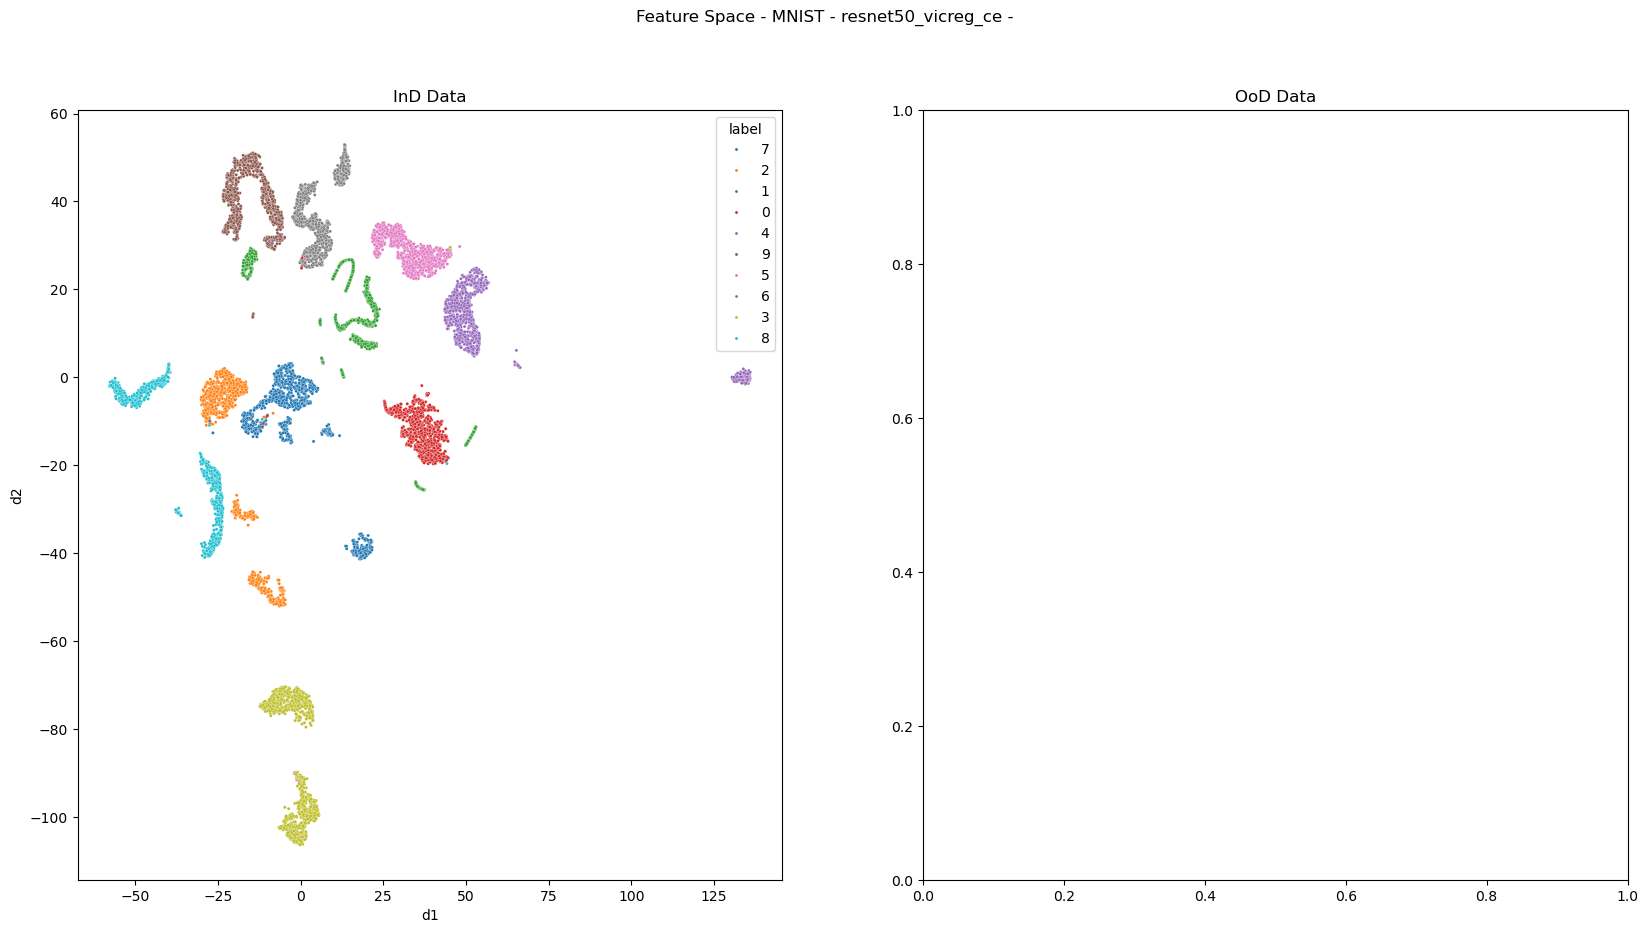

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

ftr_data = pd.DataFrame()
d1, d2 = ind_ftr2d.T
ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

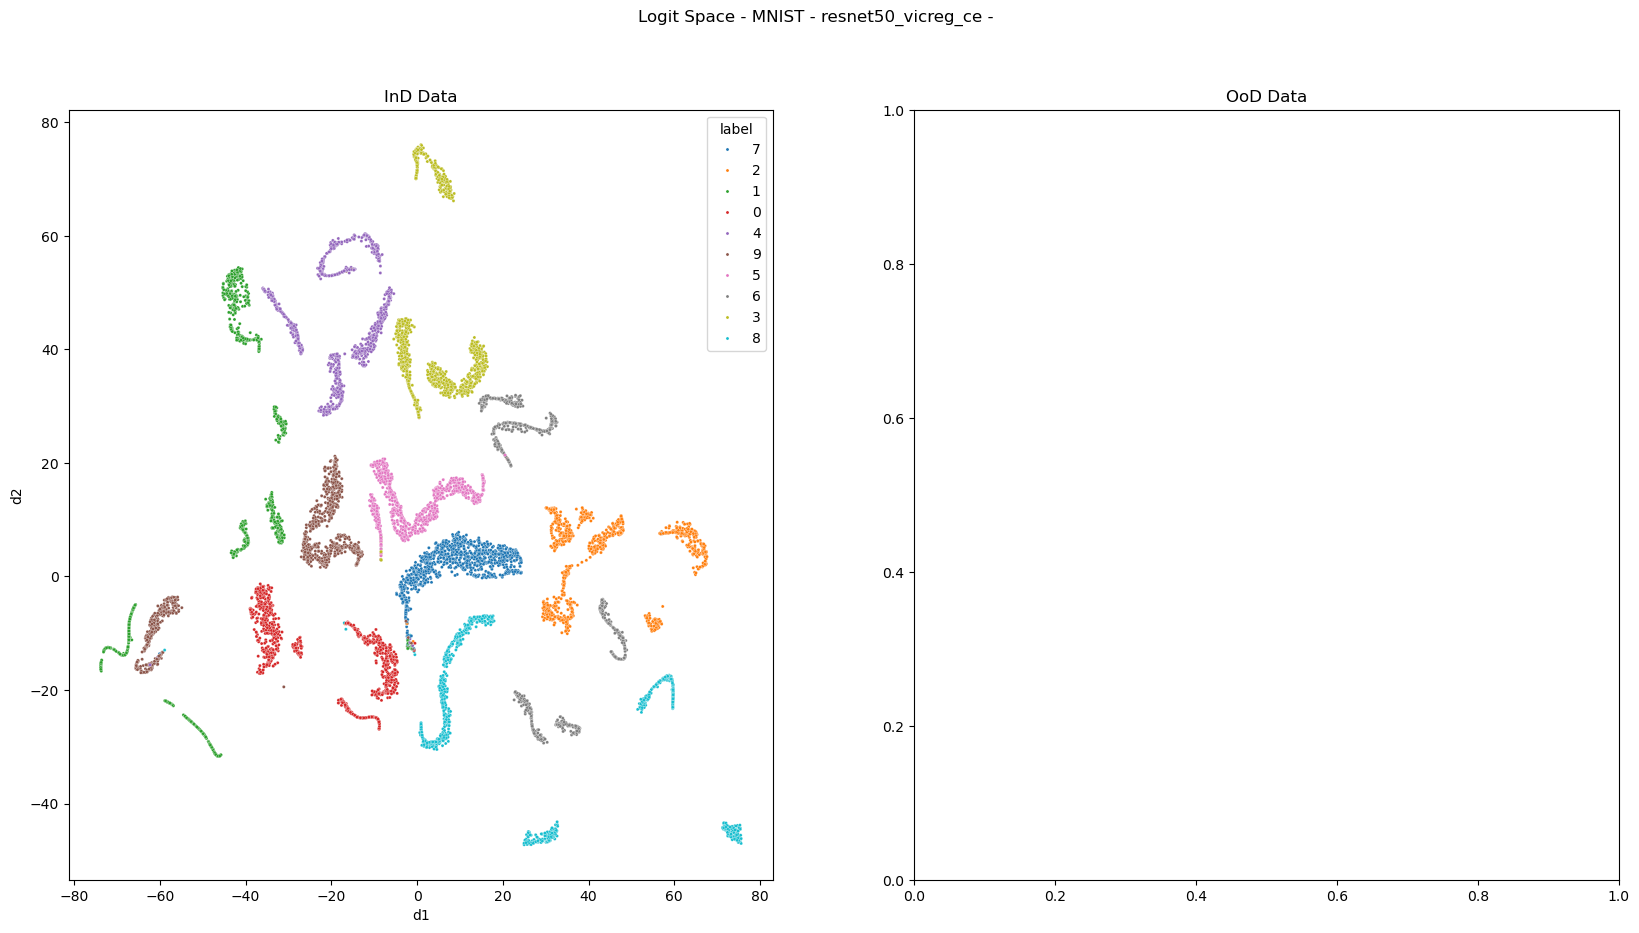

In [14]:
lgt_data = pd.DataFrame()
d1, d2 = ind_lgt2d.T
lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:02<00:07,  2.55s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:05<00:05,  2.68s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:07<00:02,  2.63s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.63s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.63s/it]

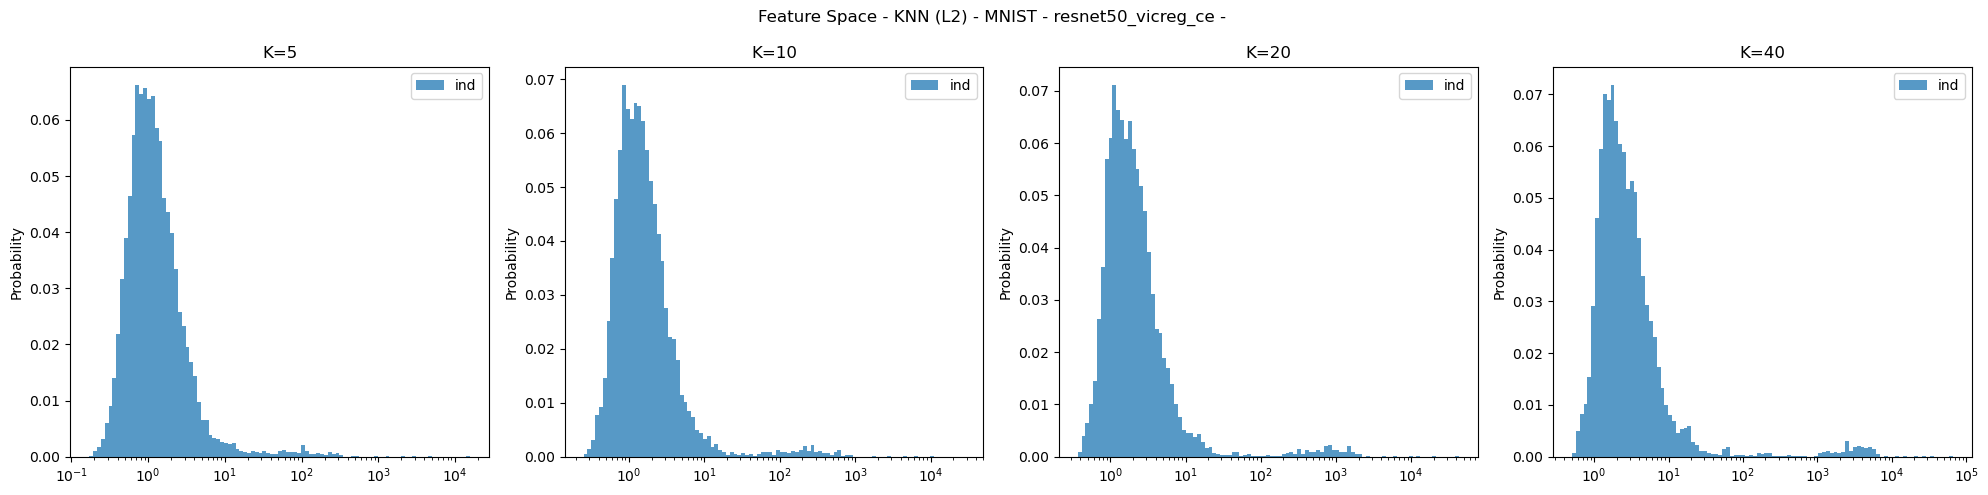

In [15]:
import faiss

index_ftr = faiss.IndexFlatL2(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:02<00:07,  2.46s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:04<00:04,  2.47s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:07<00:02,  2.48s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.52s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.50s/it]

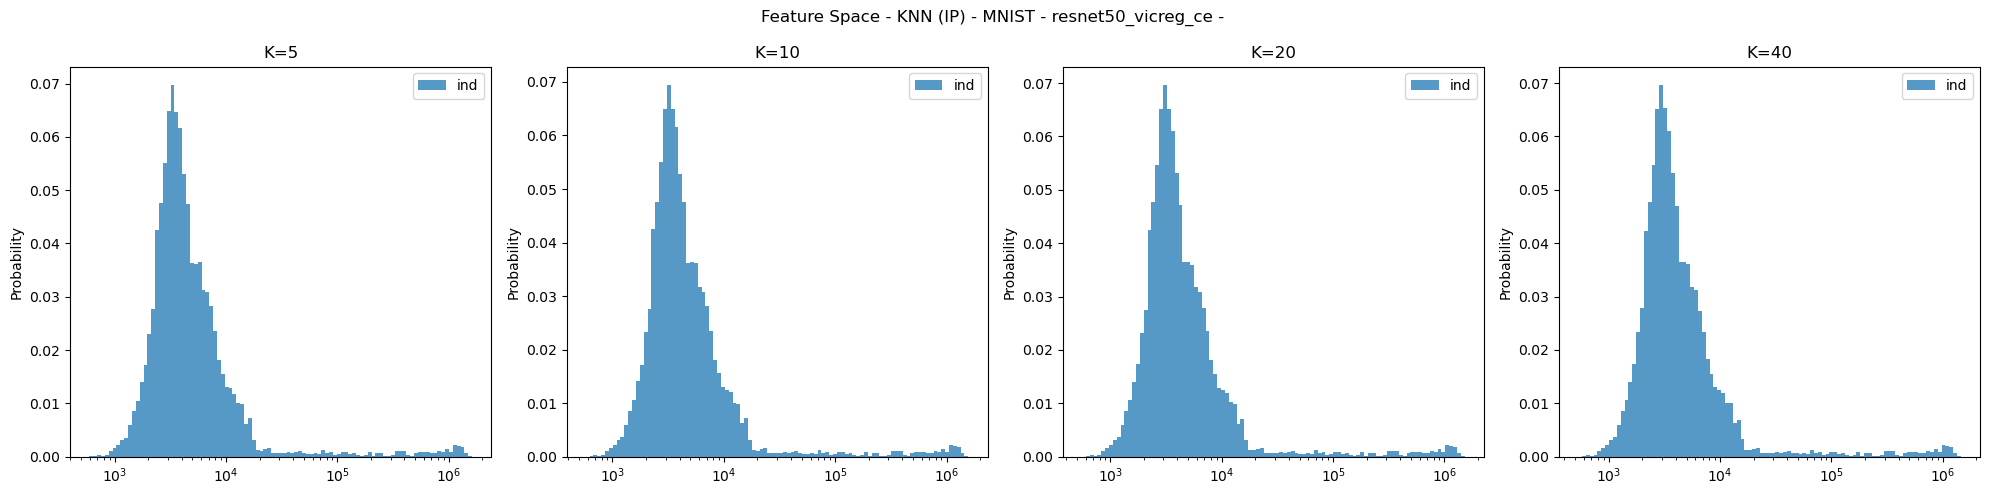

In [16]:
import faiss

index_ftr = faiss.IndexFlatIP(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:02<00:07,  2.46s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:04<00:04,  2.47s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:07<00:02,  2.49s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.51s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.50s/it]

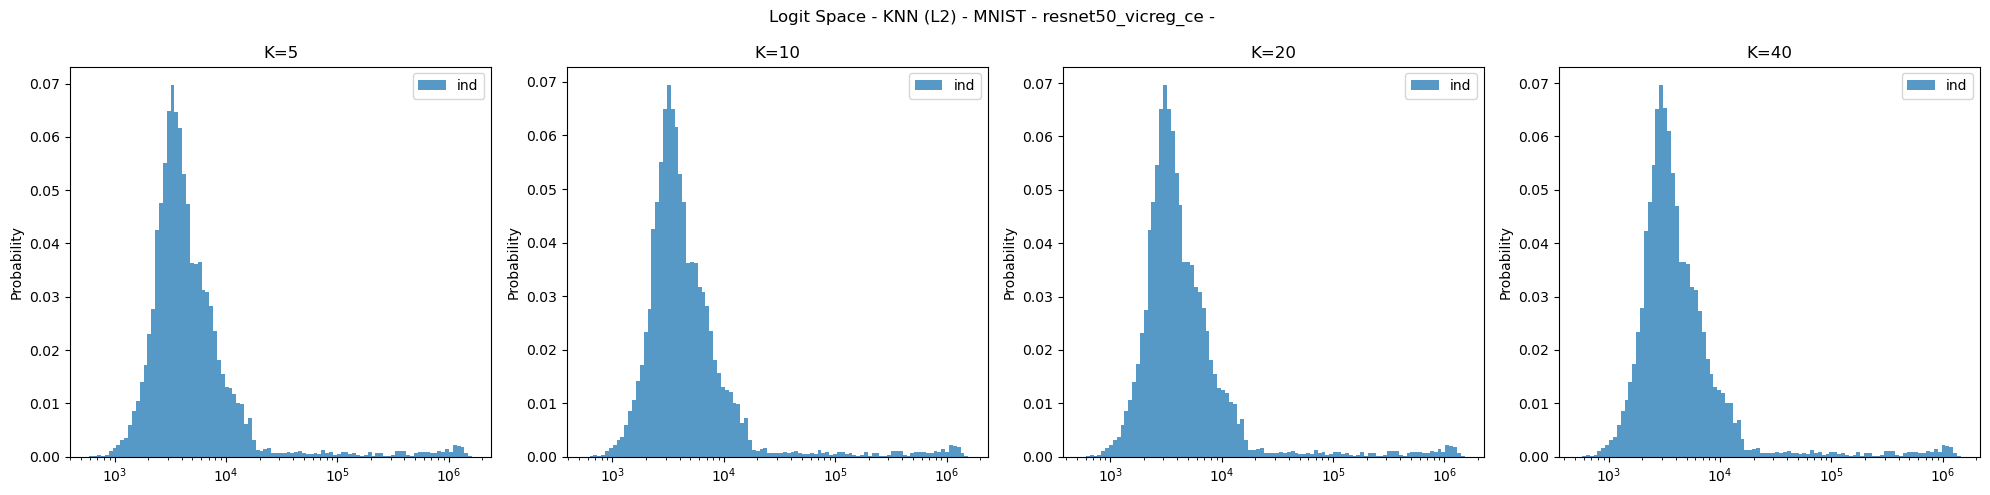

In [17]:
import faiss

index_lgt = faiss.IndexFlatL2(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:02<00:07,  2.47s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:04<00:04,  2.47s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:07<00:02,  2.48s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.51s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.50s/it]

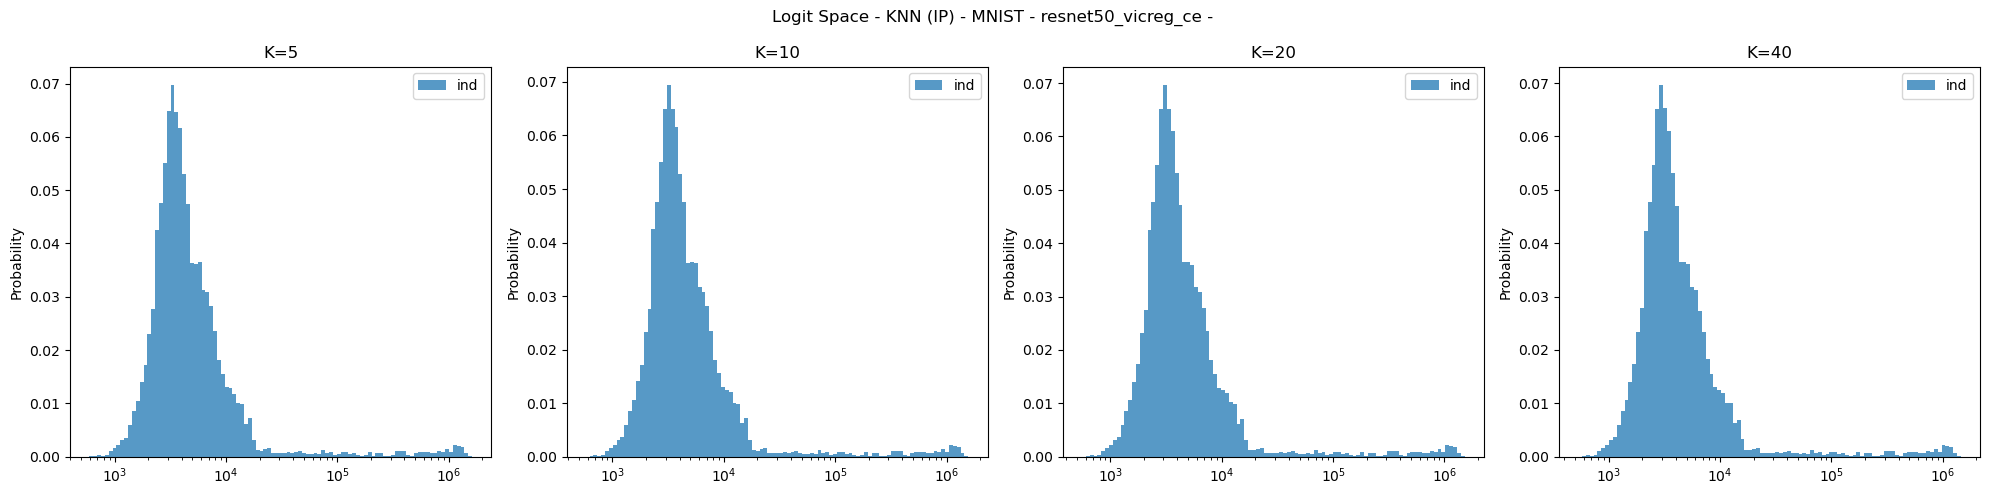

In [18]:
import faiss

index_lgt = faiss.IndexFlatIP(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

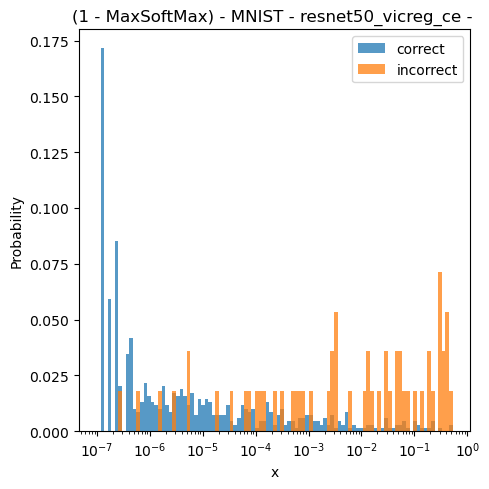

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()